In [402]:
import scipy, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
sys.path.append("/Users/alex/Desktop/Fabry-Perot/modelling")
sys.path.append(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\modelling")
sys.path.append(r"C:\Users\ge85rek\Desktop\Fabry-Perot\modelling")
import read_csv, T_and_R

In [403]:
data = read_csv.read_csv(r"/Users/alex/Desktop/Fabry-Perot/data/InGaN_FTIR.csv") #MacOS
#data = read_csv.read_csv(r"C:\Users\ge85rek\Desktop\Fabry-Perot\data\InGaN_FTIR.csv") #Labor
#data = read_csv.read_csv(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\data\InGaN_FTIR.csv") # PC
# von cm zu m 
frequenz = scipy.constants.c * np.array(data[0][::-1]) * 100
wavelength = scipy.constants.c/frequenz

In [404]:
# return index of a sorted list wherelist[index] is a specific value
def find_nearest(array, value):
    array = np.asarray(array)
    end = (np.abs(array - value)).argmin()
    return end

def flatten(data, N = 1200, cutdown = None, cutup = None):
    smooth = np.convolve(data, np.ones(N)/N, mode='same')
    return smooth[cutdown:cutup], data[cutdown:cutup]-smooth[cutdown:cutup]

def länge(m,n,f):
    lam = scipy.constants.c/f
    return m * lam / (2 * n)

def calculate_m(min_frequenz_array):
    m_array = []
    for i in range(0,len(min_frequenz_array)-1):
        m_array.append(min_frequenz_array[i]/(min_frequenz_array[i+1]-min_frequenz_array[i]))
    return m_array

def polynomial(x,a0,a1,a2,a3,a4, a5, a6):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 

def sine(x,k,A,phi):
    return A*np.sin(k*x-phi)

def refractive_index(m,L,f):
    wavelength = scipy.constants.c/f
    n = (m * wavelength) / (2 * L)
    return n 

In [405]:
cutdown = find_nearest(frequenz, 0.9e14)
cutup = find_nearest(frequenz, 2.2e14)
ends = 600
frequenz_20_cut = frequenz[cutdown:cutup]
frequenz_20_no_edge = frequenz[cutdown+ends:cutup-ends]

In [406]:
data_J130828_20 = data[8][::-1][cutdown:cutup]
data_J130828_20_no_edge = data_J130828_20[ends:-ends]

In [407]:
J13_20_smooth, J13_smoothed_out = flatten(data_J130828_20, N = 1200)
J13_20_smooth_no_edge = J13_20_smooth[ends:-ends]
J13_smoothed_out_no_edge = J13_smoothed_out[ends:-ends]

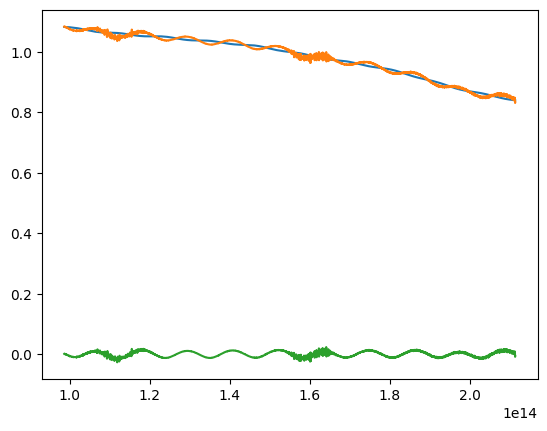

In [408]:
plt.plot(frequenz_20_no_edge, J13_20_smooth_no_edge)
plt.plot(frequenz_20_no_edge, data_J130828_20_no_edge)
plt.plot(frequenz_20_no_edge, J13_smoothed_out_no_edge)

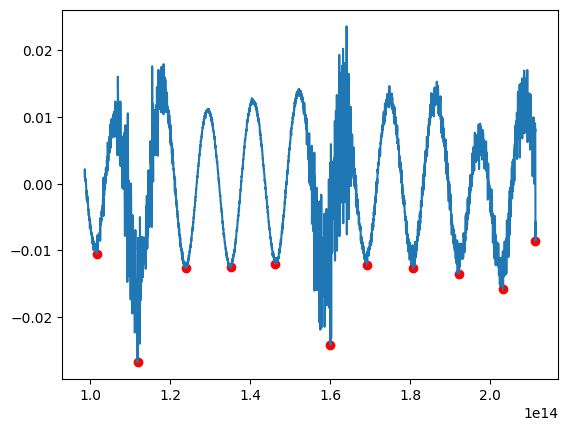

In [409]:
minima_J13_index_20 = scipy.signal.argrelmin(J13_smoothed_out_no_edge, order = 200)
minima_J13_frequenz_20 = []
minima_J13_absorption_20 = []
for m in minima_J13_index_20[0]:
    minima_J13_frequenz_20.append(frequenz_20_no_edge[m])
    minima_J13_absorption_20.append(J13_smoothed_out_no_edge[m])
plt.plot(minima_J13_frequenz_20, minima_J13_absorption_20, 'ro')
plt.plot(frequenz_20_no_edge, J13_smoothed_out_no_edge)

### Deleting unprecise points

In [410]:
#minima_J13_absorption_20 = np.delete(minima_J13_absorption_20, [1,5,8])
#minima_J13_frequenz_20 = np.delete(minima_J13_frequenz_20, [1,5,8])

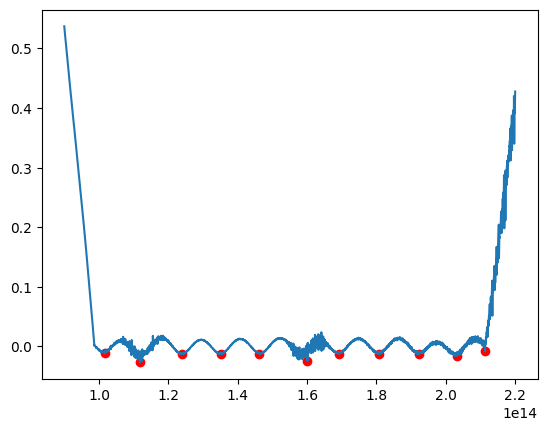

In [411]:
plt.plot(minima_J13_frequenz_20, minima_J13_absorption_20, 'ro')
plt.plot(frequenz_20_cut, J13_smoothed_out)

#### Calculating M

In [412]:
m_array_20 = calculate_m(minima_J13_frequenz_20)
m_array_20

[9.995738647071818,
 9.237470161447321,
 11.127107669295972,
 12.222222230355193,
 10.558455095501726,
 17.437795315878144,
 14.764186639882332,
 15.704773861252246,
 17.4960526401353,
 25.101785691648626]

In [413]:
m_array_20_clean = np.arange(9,20)

In [414]:
n_array_20 = []
for i in range(0,len(m_array_20_clean)):
    n_array_20.append(refractive_index(m_array_20_clean[i],4.6e-6,minima_J13_frequenz_20[i]))
n_array_20

[2.8830869966596535,
 2.9120962260791163,
 2.8904057084990575,
 2.8931598144464776,
 2.897211859150332,
 2.850135612677583,
 2.8880940666150257,
 2.8852139046303855,
 2.882026976721333,
 2.886573692774305,
 2.9302059305397945]

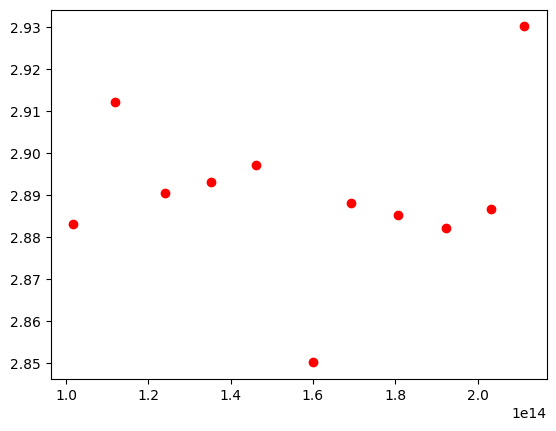

In [415]:
plt.plot(minima_J13_frequenz_20, n_array_20, 'ro')

#### Another Method: Fitting a Sine Wave

In [416]:
p0frequenz = (minima_J13_frequenz_20[1] - minima_J13_frequenz_20[0])/1e14
p0frequenz

0.10176600955757797

In [417]:
params_fit_20, cov_fit_20 = scipy.optimize.curve_fit(sine, frequenz_20_no_edge, data_J130828_20_no_edge, p0 = [2*np.pi/0.15e14,0.015,-np.pi/2])

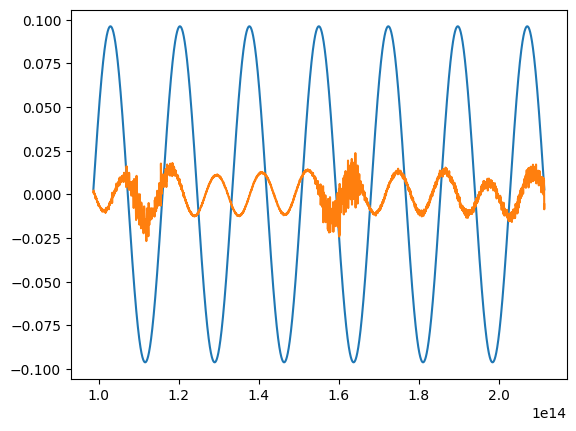

In [418]:
plt.plot(frequenz_20_no_edge, sine(frequenz_20_no_edge, *params_fit_20))
plt.plot(frequenz_20_no_edge, J13_smoothed_out_no_edge)

#### Another Method: Fitting a Polynomial to each minimum individually

In [419]:
import scipy.optimize


def fit_individually(xlim_lower_value,xlim_upper_value,x_dataset,y_dataset, p0 = [1,1,1,1,1,1,1]):
    x_lim_lower = find_nearest(x_dataset,xlim_lower_value)
    x_lim_upper = find_nearest(x_dataset,xlim_upper_value)
    x_data_modified = x_dataset[x_lim_lower:x_lim_upper]
    y_data_modified = y_dataset[x_lim_lower:x_lim_upper]
    params_fit, cov_fit = scipy.optimize.curve_fit(polynomial,x_data_modified,y_data_modified, p0 = p0)
    fitfunc = polynomial(x_data_modified,*params_fit)
    min_fit_index = scipy.signal.argrelmin(fitfunc, order = 500)
    min_fit_frequenz = x_data_modified[min_fit_index]
    min_fit_absorption = fitfunc[min_fit_index]
    plt.plot(x_data_modified,y_data_modified)
    plt.plot(min_fit_frequenz,min_fit_absorption, "ro")
    plt.plot(x_data_modified,fitfunc)
    return min_fit_frequenz,min_fit_frequenz


In [420]:
x_lower_lim_first_point = find_nearest(frequenz_20_cut,1.2e14)
x_upper_lim_first_point = find_nearest(frequenz_20_cut,1.3e14)

In [421]:
frequenz_20_first_point = frequenz_20_cut[x_lower_lim_first_point:x_upper_lim_first_point]
J13_20_first_point = J13_smoothed_out[x_lower_lim_first_point:x_upper_lim_first_point]

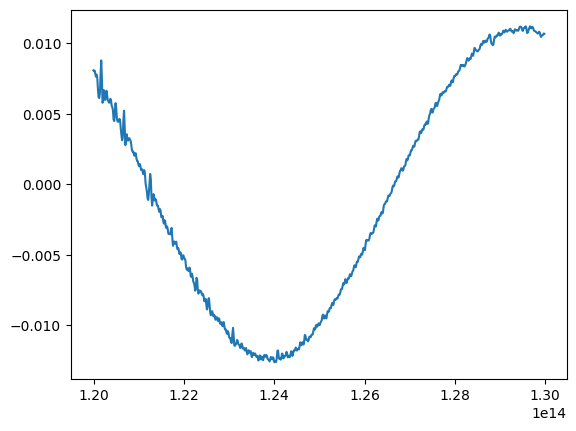

In [422]:
plt.plot(frequenz_20_first_point, J13_20_first_point)

In [423]:
params_fit_20_poly, cov_fit_20_poly = scipy.optimize.curve_fit(polynomial, frequenz_20_first_point, J13_20_first_point , p0 = [-6.74287087e+03,  2.18355941e-10, -2.64990551e-24,  1.42832983e-38,
       -2.88519169e-53,  1.00000000e-70,  1.00000000e-70])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [424]:
fitfunc_first_point = polynomial(frequenz_20_first_point, *params_fit_20_poly)

In [425]:
min_first_point_index = scipy.signal.argrelmin(polynomial(frequenz_20_first_point, *params_fit_20_poly), order = 200)
min_first_point_frequenz = frequenz_20_first_point[min_first_point_index]
min_first_point_absorption = fitfunc_first_point[min_first_point_index]

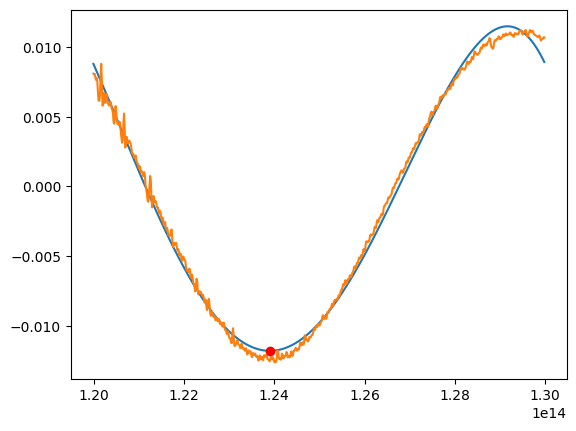

In [426]:
plt.plot(frequenz_20_first_point, polynomial(frequenz_20_first_point, *params_fit_20_poly))
plt.plot(frequenz_20_first_point, J13_20_first_point)
plt.plot(min_first_point_frequenz, min_first_point_absorption, 'ro')

In [427]:
x_lower_lim_second_point = find_nearest(frequenz_20_cut,1.3e14)
x_upper_lim_second_point = find_nearest(frequenz_20_cut,1.4e14)

frequenz_20_second_point = frequenz_20_cut[x_lower_lim_second_point:x_upper_lim_second_point]
J13_20_second_point = J13_smoothed_out[x_lower_lim_second_point:x_upper_lim_second_point]

In [428]:
params_fit_20_poly_second, cov_fit_20_poly_second = scipy.optimize.curve_fit(polynomial, frequenz_20_second_point, J13_20_second_point,p0=[-1.27051185e+04,  3.76810148e-10, -4.18895070e-24,  2.06877319e-38,
       -3.82965269e-53,1e-50,1e-50]) 

In [429]:
fitfunc_second_point = polynomial(frequenz_20_second_point, *params_fit_20_poly_second)

In [430]:
minimum_second_point_index = scipy.signal.argrelmin(polynomial(frequenz_20_second_point, *params_fit_20_poly_second), order = 200)
minimum_second_point_frequenz = frequenz_20_second_point[minimum_second_point_index]
minimum_second_point_absorption = fitfunc_second_point[minimum_second_point_index]

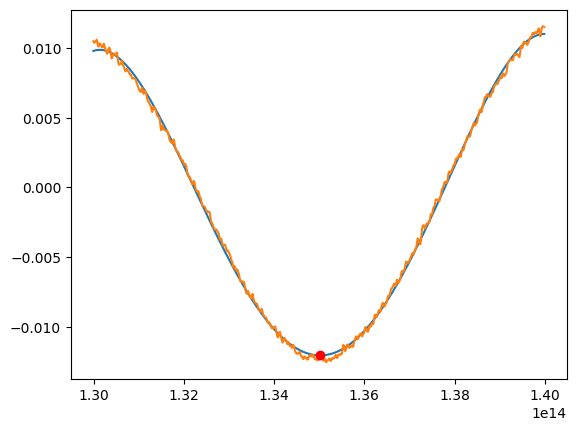

In [431]:
plt.plot(frequenz_20_second_point, polynomial(frequenz_20_second_point, *params_fit_20_poly_second))
plt.plot(frequenz_20_second_point, J13_20_second_point)
plt.plot(minimum_second_point_frequenz, minimum_second_point_absorption, 'ro')

In [432]:
x_lower_lim_third_point = find_nearest(frequenz_20_cut,1.4e14)
x_upper_lim_third_point = find_nearest(frequenz_20_cut,1.5e14)

frequenz_20_third_point = frequenz_20_cut[x_lower_lim_third_point:x_upper_lim_third_point]
J13_20_third_point = J13_smoothed_out[x_lower_lim_third_point:x_upper_lim_third_point]

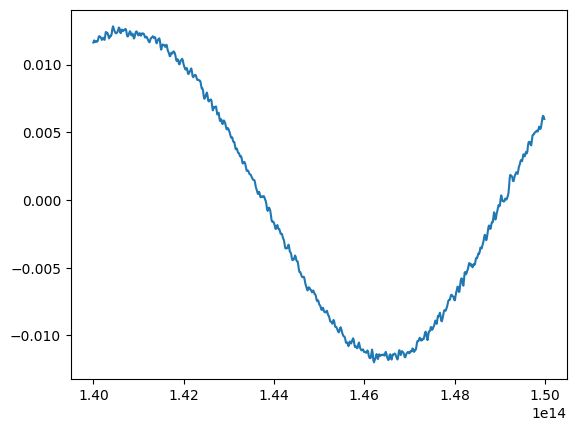

In [433]:
plt.plot(frequenz_20_third_point, J13_20_third_point)

In [434]:
params_fit_20_poly_third, cov_fit_20_poly_third = scipy.optimize.curve_fit(polynomial, frequenz_20_third_point, J13_20_third_point,p0 = [-9.92286406e+03,  2.70558277e-10, -2.76474918e-24,  1.25489110e-38,
       -2.13463468e-53,1e-50,1e-50] )

In [435]:
fitfunc_third_point = polynomial(frequenz_20_third_point, *params_fit_20_poly_third)

In [436]:
minimum_third_point_index = scipy.signal.argrelmin(fitfunc_third_point, order = 200)
minimum_third_point_frequenz = frequenz_20_third_point[minimum_third_point_index]
minimum_third_point_absorption = fitfunc_third_point[minimum_third_point_index]

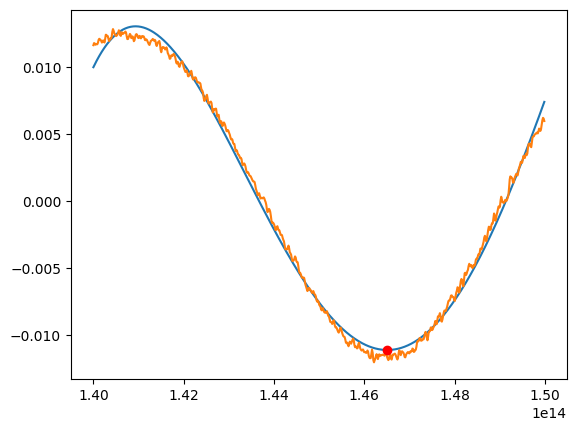

In [437]:
plt.plot(frequenz_20_third_point, polynomial(frequenz_20_third_point, *params_fit_20_poly_third))
plt.plot(frequenz_20_third_point, J13_20_third_point)
plt.plot(minimum_third_point_frequenz, minimum_third_point_absorption, 'ro')

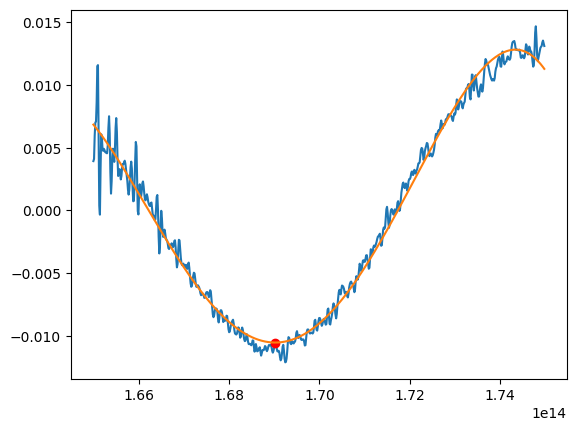

In [438]:
frequenz_20_fouth_point, absorption_20_fourth_point = fit_individually(1.65e14,1.75e14,frequenz_20_cut,J13_smoothed_out)

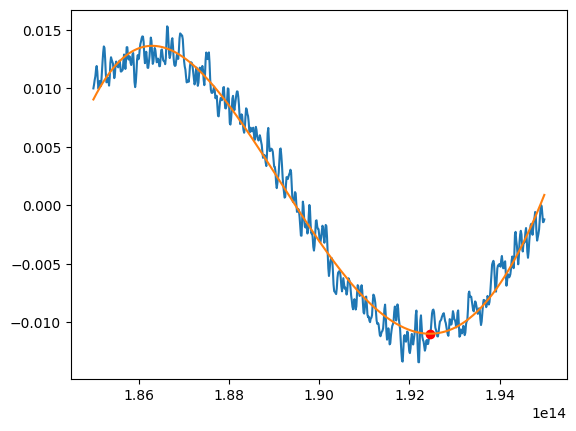

In [439]:
frequenz_20_fifth_point, absorption_20_fifth_point = fit_individually(1.85e14,1.95e14,frequenz_20_cut,J13_smoothed_out)

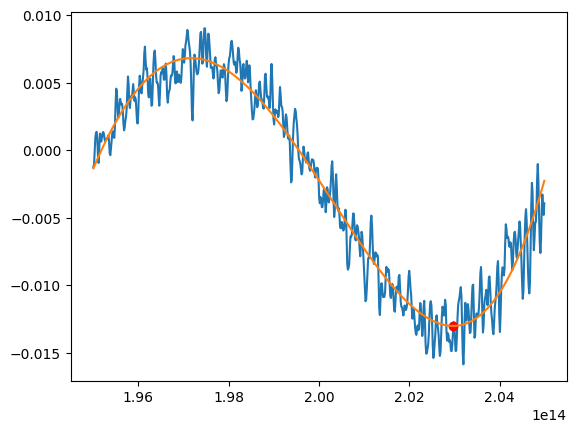

In [440]:
frequenz_20_sixth_point, absorption_20_sixth_point = fit_individually(1.95e14,2.05e14,frequenz_20_cut,J13_smoothed_out)

In [441]:
minima_total_frequenz = [min_first_point_frequenz, minimum_second_point_frequenz, minimum_third_point_frequenz]
minima_total_absorption = [min_first_point_absorption, minimum_second_point_absorption, minimum_third_point_absorptionlsl]

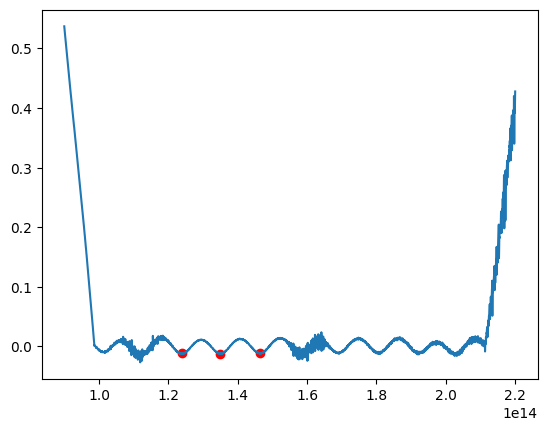

In [442]:
plt.plot(minima_total_frequenz, minima_total_absorption, 'ro')
plt.plot(frequenz_20_cut, J13_smoothed_out)

In [443]:
m_array_total = calculate_m(minima_total_frequenz)
m_array_total

[array([11.1456437]), array([11.74842766])]

In [444]:
m_array_total_clean = np.arange(10,13)
n_array_total = []
for i in range(0,len(m_array_total_clean)):
    n_array_total.append(refractive_index(m_array_total_clean[i],4.6e-6,minima_total_frequenz[i]))
n_array_total

[array([2.63009414]), array([2.65490263]), array([2.66907195])]

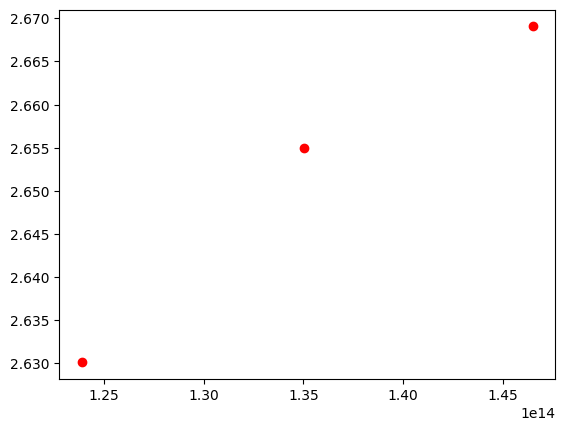

In [445]:
plt.plot(minima_total_frequenz, n_array_total, 'ro')

In [446]:
params_fit_20_poly

array([-6.73043662e+03,  2.17957753e-10, -2.64512485e-24,  1.42577944e-38,
       -2.88009067e-53,  1.00000000e-70,  1.00000000e-70])

In [447]:
params_fit_20_poly_second

array([-1.27054686e+04,  3.76820516e-10, -4.18906586e-24,  2.06883002e-38,
       -3.82975785e-53,  1.00000000e-50,  1.00000000e-50])

In [448]:
params_fit_20_poly_third

array([-9.99455384e+03,  2.72536925e-10, -2.78522482e-24,  1.26430675e-38,
       -2.15086847e-53,  1.00000000e-50,  1.00000000e-50])

In [449]:
p01 = [-6.74287087e+03,  2.18355941e-10, -2.64990551e-24,  1.42832983e-38,
       -2.88519169e-53]
p02 = [-1.27051185e+04,  3.76810148e-10, -4.18895070e-24,  2.06877319e-38,
       -3.82965269e-53]
p03 = [-9.92286406e+03,  2.70558277e-10, -2.76474918e-24,  1.25489110e-38,
       -2.13463468e-53]